# Data Processing and Temperature Forecasting Model

## Objective

Develop a regression model to forecast temperature across monitored locations using the data collected from IoT sensors.  
Humidity will not be modeled in this stage, as it tends to be more variable and would require additional environmental inputs to achieve robust and reliable predictions.

Temperature variability is generally more stable than humidity, which is strongly influenced by external factors such as wind speed and direction, rainfall, and evaporation.  
Although temperature is also affected by these environmental conditions, its variation over time tends to be smoother and less pronounced compared to humidity changes.

## Context

This notebook covers the end-to-end processing of sensor data retrieved from InfluxDB, including time alignment, data cleaning, handling missing values, and feature preparation for model training.  

The resulting dataset will be used to train and evaluate a regression model capable of forecasting temperature one step ahead (minute-by-minute) for each monitored location. This stage represents the analytical and modeling component of the IoT forecasting pipeline.


## Introduction

Temperature is one of the most influential physical variables in both natural and engineered systems. From industrial operations to biological processes, it governs performance, stability, and safety.  

It is a crucial factor across many industries. In the **oil and gas** sector, it is used to identify hostile environments that require specialized tools made from advanced materials capable of withstanding high temperatures.  

In the **automotive** industry, monitoring and controlling temperature, often through chemical processes and material engineering, is essential for the correct operation of both combustion and electric engines.  

In **medicine**, temperature serves as a key health indicator, helping detect abnormal physiological conditions in patients.

Nonetheless, even when **environmental temperature** is not considered as critical as in the previous examples, it still plays a fundamental role. Knowing the environmental temperature is essential in **manufacturing assembly lines**, **agricultural fields**, **food preservation**, and **medicine production**, among other applications.  

Fortunately, due to its nature, **environmental temperature is more stable than operational temperatures**, making it easier to predict. This allows automated systems to adjust devices such as fans, air conditioners, or heating units to maintain optimal conditions and achieve the best possible results.

In this notebook, a simple approach is implemented to predict environmental variables based on real measurements acquired through IoT devices.


## Importing Required Libraries

In [1]:
from influxdb_client import InfluxDBClient              # Connect to the InfluxDB time-series database
from dotenv import load_dotenv                          # Load environment variables securely (e.g., passwords, tokens)
from datetime import datetime, timezone                 # Work with date and time objects
import matplotlib.dates as mdates                       # Format time-series plots in Matplotlib
import pandas as pd                                     # Manipulate tabular data using DataFrames
import numpy as np                                      # Perform numerical and array-based operations
import seaborn as sns                                   # Statistical data visualization
import matplotlib.pyplot as plt                         # Core plotting library
import scipy as sci                                     # Scientific computing and advanced mathematical operations
from sklearn.preprocessing import StandardScaler        # Normalize/standardize features for ML models
import statsmodels.api as sm                            # Statistical modeling and hypothesis testing
from sklearn.model_selection import train_test_split    # Split data into training and testing sets
from sklearn.metrics import mean_absolute_error         # Evaluate model error (average absolute difference)|
from sklearn.metrics import mean_squared_error          # Evaluate model error (average squared difference)
from sklearn.metrics import r2_score                    # Evaluate model performance (variance explained)
from statsmodels.graphics.tsaplots import plot_acf      # Plot autocorrelation function for time-series analysis
import os                                               # Operating system interface (paths, environment, files)
from IPython.display import Markdown                    # Render formatted Markdown output in notebooks
from sklearn.linear_model import Ridge                  # Ridge (L2-regularized) linear regression model
from sklearn.model_selection import GridSearchCV        # Automated hyperparameter tuning (e.g., alpha in Ridge)
from sklearn.model_selection import TimeSeriesSplit     # Cross-validation for ordered time-series data
from Functions import Ridge_Regression_Results          # Custom visualization function for Ridge results
from sklearn.ensemble import RandomForestRegressor      # Tree-based ensemble model for regression tasks
import joblib                                           # 

from statsmodels.stats.outliers_influence import variance_inflation_factor  # Detect multicollinearity (VIF)

%matplotlib inline                              

## Data Wrangling (ETL + Data Cleaning)

### Data Extraction

The following cell retrieves data from the configured InfluxDB instance, using the credentials and access tokens defined in the **.env** file.


In [2]:
# 1) Credentials and client
load_dotenv()
url    = os.getenv("INFLUX_URL")
token  = os.getenv("INFLUX_TOKEN")
org    = os.getenv("INFLUX_ORG")
bucket = os.getenv("INFLUX_BUCKET")
local_tz = os.getenv("LOCAL_TZ", "America/Merida")
# Connecting to the influxDB
client = InfluxDBClient(url=url, token=token, org=org)

# Defining query for data extraction
q = f"""
from(bucket: "{bucket}")
  |> range(start: 0)
  |> filter(fn: (r) => r._measurement == "dht22")
  |> filter(fn: (r) => r._field == "temp_c" or r._field == "hum")
  |> map(fn: (r) => ({{ r with _value: float(v: r._value) }}))
  |> aggregateWindow(every: 1m, fn: mean, createEmpty: false)
  |> pivot(rowKey: ["_time","topic"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time","topic","temp_c","hum"])
  |> sort(columns: ["_time"])
"""

# Querying the influxDB
df = client.query_api().query_data_frame(q)

# Creating a pandas dataframe woth the retrieved data
if isinstance(df, list):
    df = pd.concat(df, ignore_index=True)

# Formatting the created pandas dataframe
df = (df.rename(columns={"_time": "time", "topic": "location", "temp_c":"temp"})
        [["time","location","temp","hum"]]
        .sort_values("time")
        .reset_index(drop=True))

# Adjusting locations names
df["location"] = df["location"].astype(str).apply(lambda x: x.split('/')[1] if '/' in x else x)

locations = ['LivingRoom', 'Room', 'Kitchen', 'office']
for loc in locations:
    df.loc[df["location"][df["location"].str.contains(loc)].index, 'location'] = loc.lower()

# Adjusting datetime to local timezone (acquisition timezone)
df["time"] = df["time"].dt.tz_convert("America/Mexico_City")

- Retrieved data sample:

In [3]:
df.sample(8)

,time,location,temp,hum
32958,2025-11-09 13:53:00-06:00,office,33.000000,65.700008
14205,2025-11-04 16:48:00-06:00,room,26.900000,83.800000
33942,2025-11-09 19:22:00-06:00,kitchen,29.300002,82.700008
10841,2025-11-04 00:03:00-06:00,livingroom,24.500000,61.900000
2643,2025-11-02 09:09:00-06:00,kitchen,28.000000,76.200008
18681,2025-11-05 15:02:00-06:00,office,28.700000,80.200008
2713,2025-11-02 09:33:00-06:00,kitchen,27.700000,78.300000
5806,2025-11-02 23:54:00-06:00,livingroom,26.300002,64.300000


#### Ploting Retrieved Data

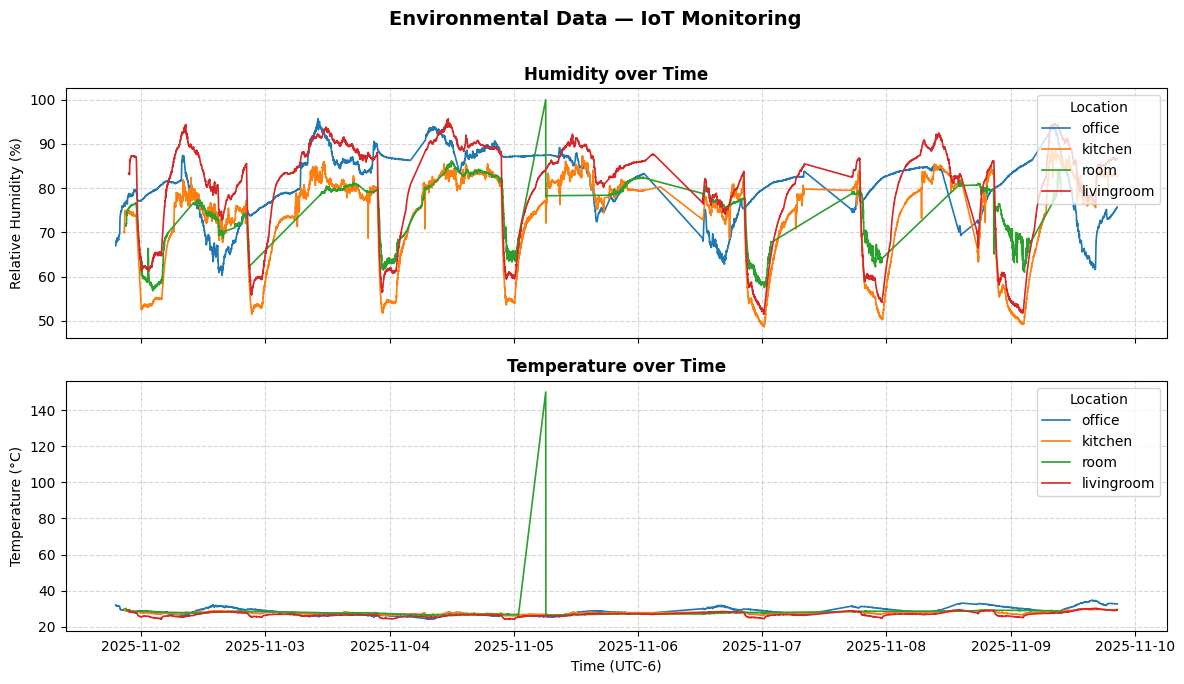

In [4]:
# Defining the figure and axes
fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# --- Humidity ---
sns.lineplot(data=df, x="time", y="hum", hue="location", ax=axs[0], linewidth=1.2)
axs[0].set_title("Humidity over Time", fontsize=12, fontweight='bold')
axs[0].set_ylabel("Relative Humidity (%)")
axs[0].legend(title="Location", loc='upper right')
axs[0].grid(True, linestyle="--", alpha=0.5)

# --- Temperature ---
sns.lineplot(data=df, x="time", y="temp", hue="location", ax=axs[1], linewidth=1.2)
axs[1].set_title("Temperature over Time", fontsize=12, fontweight='bold')
axs[1].set_ylabel("Temperature (°C)")
axs[1].legend(title="Location", loc='upper right')
axs[1].grid(True, linestyle="--", alpha=0.5)

# --- General formatting ---
fig.suptitle("Environmental Data — IoT Monitoring", fontsize=14, fontweight='bold', y=0.97)
plt.xlabel("Time (UTC-6)")
plt.tight_layout(rect=[0, 0, 1, 0.96])

### Data Transformation and Cleaning

#### Transforming the DataFrame

Before analysis, the raw data must be properly structured. Sensor measurements are organized by timestamp and location to detect inconsistencies, handle missing values, and ensure the dataset is ready for modeling and visualization.


In [5]:
# Define the date from which valid measurements are recorded
fecha_corte = "2025-11-02 00:00:00"

# Filter and reset index
df = df[df["time"] >= fecha_corte].reset_index(drop=True)

# --- Transforming DataFrame ---
# Pivot temperature and humidity by location
pivot_temp = df.pivot(index="time", columns="location", values="temp")
pivot_hum  = df.pivot(index="time", columns="location", values="hum")

# Rename columns for clarity
pivot_temp.columns = [f"temp_{loc}" for loc in pivot_temp.columns]
pivot_hum.columns  = [f"hum_{loc}"  for loc in pivot_hum.columns]

# Combine the two pivoted DataFrames
df = pd.concat([pivot_temp, pivot_hum], axis=1).reset_index()

- Transformed Dataframe Sample:

In [6]:
df.sample(8)

,time,temp_kitchen,temp_livingroom,temp_office,temp_room,hum_kitchen,hum_livingroom,hum_office,hum_room
8216,2025-11-08 18:12:00-06:00,29.300002,28.600000,32.800000,29.1,73.700008,76.200008,73.1,80.200008
3052,2025-11-04 02:52:00-06:00,27.000000,25.800002,25.600000,26.9,68.200008,73.800000,86.4,69.600000
1790,2025-11-03 05:50:00-06:00,27.700000,26.800002,27.300002,NaN,75.700008,83.800000,79.4,NaN
8625,2025-11-09 01:01:00-06:00,26.900000,25.500000,30.400000,29.1,50.700000,53.900000,84.1,69.300000
8110,2025-11-08 13:16:00-06:00,28.700000,29.100000,NaN,NaN,80.900000,82.100000,NaN,NaN
5133,2025-11-05 13:33:00-06:00,27.500000,26.800002,28.400000,NaN,85.400000,89.600000,85.0,NaN
3516,2025-11-04 10:36:00-06:00,27.400000,25.900000,26.200000,NaN,83.700008,93.100000,91.8,NaN
2966,2025-11-04 01:26:00-06:00,26.700000,25.000000,25.900000,27.0,58.200000,63.200000,86.6,65.200008


#### Evaluating timestamp gaps to ensure sequence stability

The first and last records will appear as gap inconsistencies due to the lack of adjacent records for comparison.

In [7]:
# Sort records chronologically
df = df.sort_values("time").reset_index(drop=True)

# Calculate time gaps between consecutive records
df["delta"] = df["time"].diff()

# Identify inconsistencies (gaps different from 60 seconds)
anomalous_gaps = df.loc[df["delta"] != pd.Timedelta(seconds=60)]

# Display potential issues
anomalous_gaps.head()

,time,temp_kitchen,temp_livingroom,temp_office,temp_room,hum_kitchen,hum_livingroom,hum_office,hum_room,delta
0,2025-11-02 00:00:00-06:00,NaN,25.5,28.800002,NaN,NaN,62.100004,77.200008,NaN,NaT
5370,2025-11-05 17:32:00-06:00,NaN,27.2,NaN,NaN,NaN,81.000000,NaN,NaN,0 days 00:03:00
5371,2025-11-05 18:18:00-06:00,27.5,NaN,NaN,27.0,78.0,NaN,NaN,78.4,0 days 00:46:00
5786,2025-11-06 01:18:00-06:00,NaN,27.1,NaN,NaN,NaN,86.200008,NaN,NaN,0 days 00:06:00
5788,2025-11-06 01:21:00-06:00,NaN,27.2,NaN,NaN,NaN,86.300000,NaN,NaN,0 days 00:02:00


#### Cleaning the Transformed DataFrame

Once transformed, the new DataFrame must be processed to remove inconsistencies, the most critical being null and unknown values. The following figure shows the presence and distribution of null values within the transformed DataFrame structure.

- ***FInding Null Values***


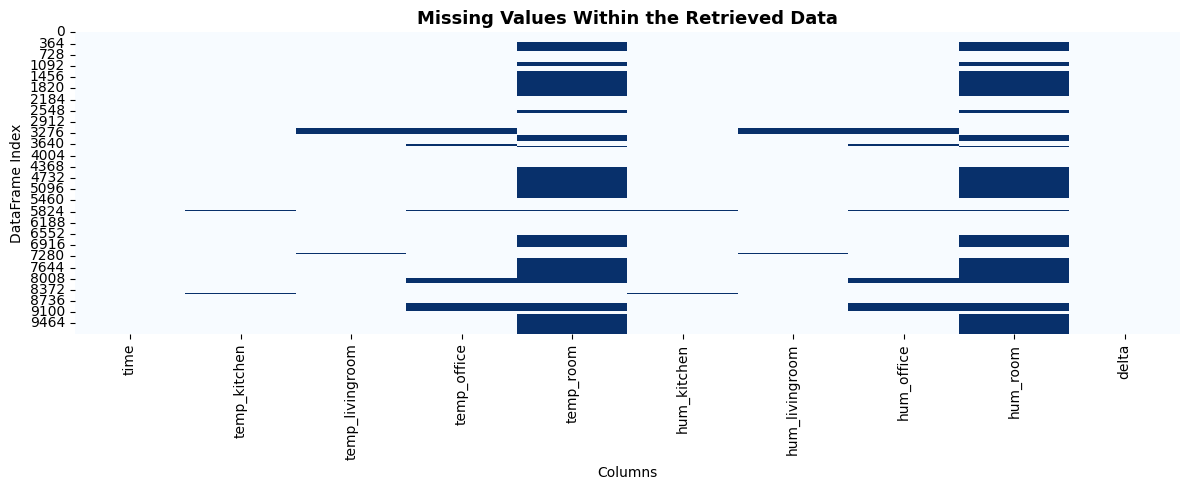

In [8]:
# Investigate patterns of missing values across DataFrame columns
fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(df.isnull(), cbar=False, cmap="Blues")

ax.set_title("Missing Values Within the Retrieved Data", fontsize=13, fontweight='bold')
ax.set_xlabel("Columns")
ax.set_ylabel("DataFrame Index")

plt.tight_layout()


- ***Removing Null Values***

  Dropping columns with a considerable amount of null values. These measurements could be used later to generate an additional solution once a sufficient amount of reliable data is collected.

In [9]:
# Remove columns with a high amount of null values
df.drop(columns=["temp_room", "hum_room", "delta"], inplace=True, errors="ignore")

- ***Imputing Remaining Null Values***

  The remaining null values are imputed through interpolation between adjacent measurements, considering the smooth temporal behavior of the variables. Since temperature and humidity exhibit gradual variations over time, occasional missing values can be reliably estimated using the mean of neighboring observations.


In [10]:
# Impute remaining null values by linear interpolation
df.interpolate(method='linear', limit_direction='both', inplace=True)

#### Validating Data Transformation and Cleaning

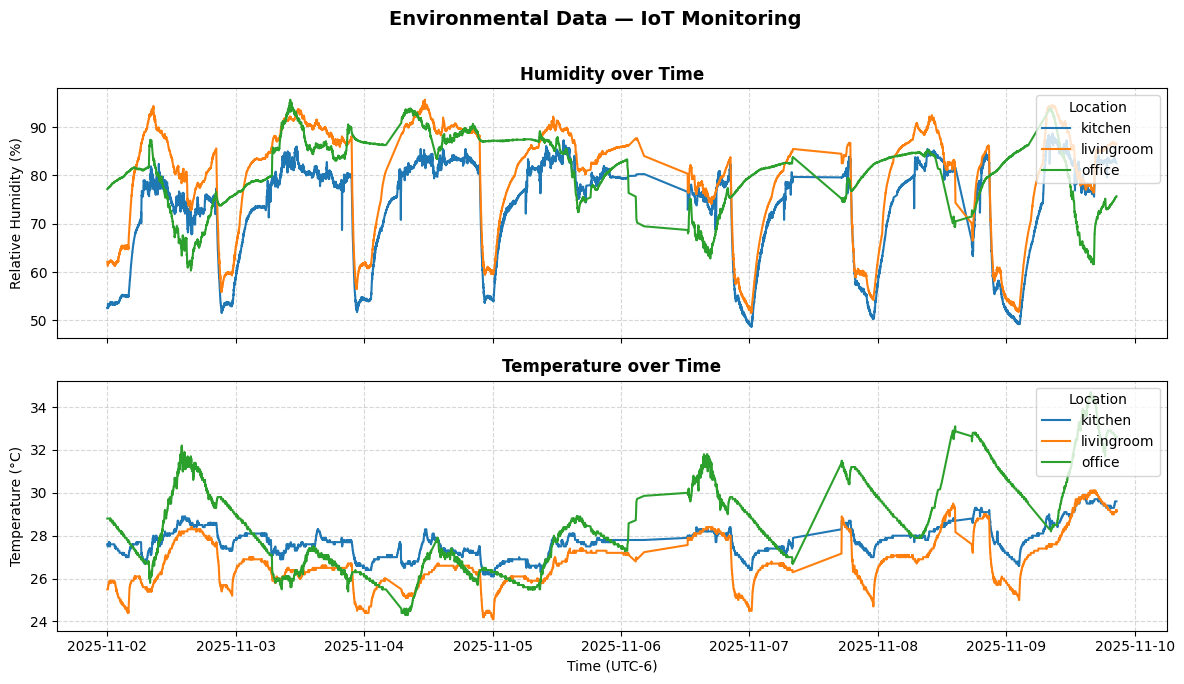

In [11]:
# Adjusting datetime to local timezone (acquisition timezone)
df["time"] = df["time"].dt.tz_convert("America/Mexico_City")

# Defining the figure and axes
fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

x = df["time"]  # tz-aware: America/Mexico_City

for col in df.columns[1:]:
    if 'hum' in col:
        axs[0].plot(x, df[col], label=col.split('_')[1])
        axs[0].set_title("Humidity over Time", fontsize=12, fontweight='bold')
        axs[0].set_ylabel("Relative Humidity (%)")
        axs[0].legend(title="Location", loc='upper right')
        axs[0].grid(True, linestyle="--", alpha=0.5)
    elif 'temp' in col:
        axs[1].plot(x, df[col], label=col.split('_')[1])
        axs[1].set_title("Temperature over Time", fontsize=12, fontweight='bold')
        axs[1].set_ylabel("Temperature (°C)")
        axs[1].legend(title="Location", loc='upper right')
        axs[1].grid(True, linestyle="--", alpha=0.5)

# --- General formatting ---
fig.suptitle("Environmental Data — IoT Monitoring", fontsize=14, fontweight='bold', y=0.97)
plt.xlabel("Time (UTC-6)")
plt.tight_layout(rect=[0, 0, 1, 0.96])

### Data Loading

In [12]:
# Generate timestamped filename
filename = f"Data/cleaned_iot_data_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"

# Convert timezone-aware datetime to string (for CSV compatibility)
df_export = df.copy()
df_export["time"] = df_export["time"].dt.tz_convert("America/Mexico_City").dt.strftime("%Y-%m-%d %H:%M:%S")

# Save transformed data
df_export.to_csv(filename, index=False)
print(f"Cleaned data saved to '{filename}'")


Cleaned data saved to 'Data/cleaned_iot_data_20251109_2035.csv'


## __________________________________________________________________________________________________________

## EDA (Exploratory Data Analysis)

Once the data has been properly preprocessed, underlying patterns and key characteristics can be explored to generate the expected solution.  

Given the simplicity of this project, an exhaustive analysis will not be performed. Nevertheless, this step ensures a correct definition of features useful for relating previous measurement values with the forecasted ones.



### Descriptive Analysis

The following table presents summary statistics for the measured data. It can be observed that the **office** consistently reaches the highest temperature and humidity values within the building, while the **kitchen** shows the least variability in both measurements.

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp_kitchen,9801.0,27.732867,0.749529,26.100000,27.200000,27.7,28.100000,29.900000
temp_livingroom,9801.0,26.761214,1.219460,24.100000,25.900000,26.6,27.300002,30.100000
temp_office,9801.0,28.473068,2.166015,24.300002,26.800002,28.2,29.900000,34.700000
hum_kitchen,9801.0,73.405080,10.442675,48.600004,68.500000,77.1,81.300000,88.700008
hum_livingroom,9801.0,79.530554,11.259761,51.500000,74.300000,83.0,88.500000,95.700008
hum_office,9801.0,81.403615,7.159765,60.300000,77.300000,82.6,87.000000,95.700008


### Correlation Analysis

In addition to the previous findings, it can be observed, based on the linear correlation between measurements, that the **kitchen** and **living room** exhibit very similar behavior, while the **office** shows a weaker correlation with the other rooms. This result is expected, as the office is located outside the main building, whereas the kitchen and living room are both inside the house.

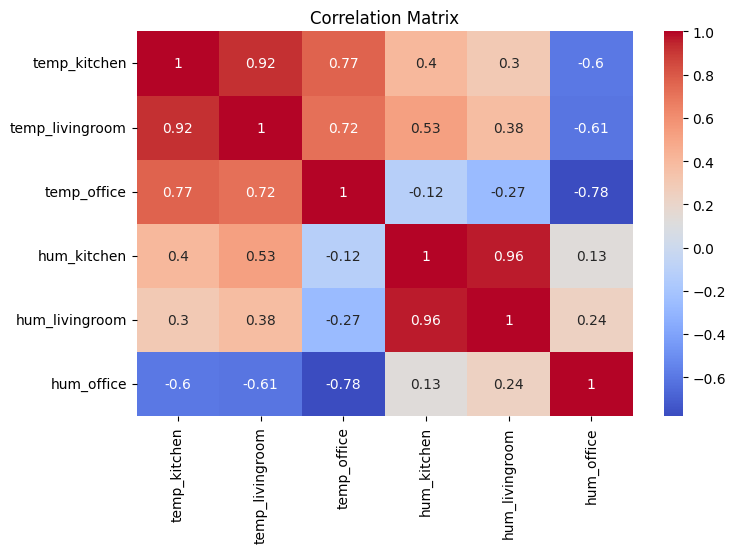

In [14]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### Distribution Analysis

The following figure shows the distribution and relationships between temperature measurements. Only temperature variables are plotted, as these are the ones to be predicted. A clear linear relationship can be observed between **kitchen** and **living room** temperatures. However, even though some linear correlations are also present between the **office** and the other rooms, not all data follows this trend, some patterns may arise from **non-linear relationships** or **external factors** affecting only the office environment.  

Furthermore, regarding the distribution of measurements by location, it can be seen that the **kitchen** presents an approximately unbiased Gaussian behavior, while the **office** shows a **right-skewed Gaussian distribution**. In contrast, the **living room** displays a more **unstable or irregular distribution**, likely due to higher temperature fluctuations.


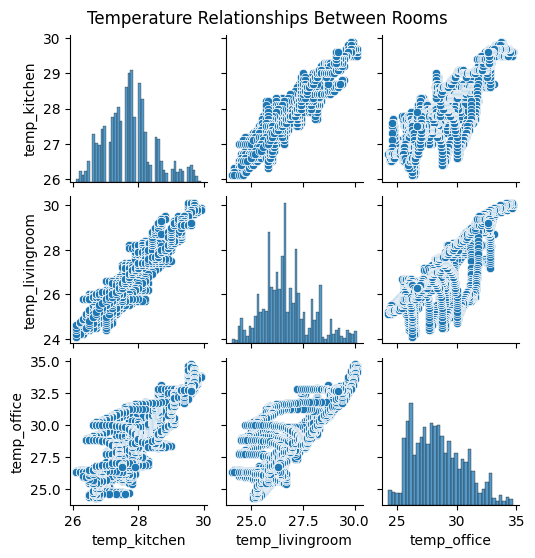

In [15]:
cols_temp = [col for col in df.columns if 'temp' in col]
g = sns.pairplot(df[cols_temp], height=1.8)
g.fig.suptitle("Temperature Relationships Between Rooms", y=1.02);

#### Normality Analysis

From the previous analysis, it was observed that the **kitchen** temperature behaves similarly to a Gaussian process, while the **office** temperature also follows a roughly normal pattern but with a slight right skewness.  

To validate these assumptions, **QQ-plots** were used to visually assess how well both measurements align with a theoretical normal distribution, as shown below. The results confirm that both datasets exhibit an approximately Gaussian behavior, with minor deviations in the tails.

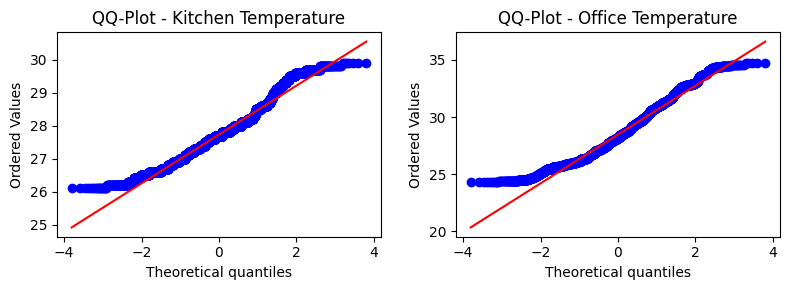

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 1 fila, 2 columnas

# QQ-plot para kitchen
sci.stats.probplot(df["temp_kitchen"], dist="norm", plot=axes[0])
axes[0].set_title("QQ-Plot - Kitchen Temperature")

# QQ-plot para office
sci.stats.probplot(df["temp_office"], dist="norm", plot=axes[1])
axes[1].set_title("QQ-Plot - Office Temperature")

plt.tight_layout()


### Temporal Behavior

This analysis aims to understand how the measurements behave over time, using different data aggregations such as per-minute, hourly, and even daily intervals. However, at this stage of the project, the potential trends or patterns to be identified are limited by the amount of data currently available. For this type of analysis, a longer data collection period is required to capture meaningful temporal dynamics.

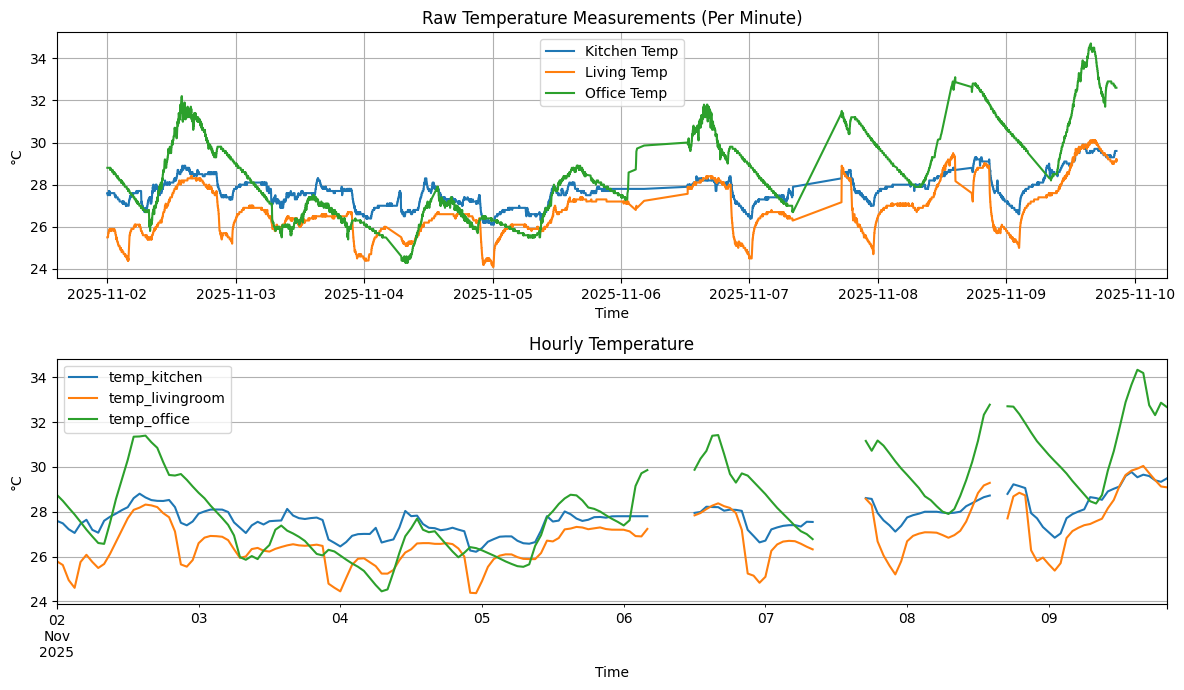

In [17]:
# Creating the dataset for plotting temporal behaivours
df_temp = df.copy(deep=True)
df_temp['_time'] = pd.to_datetime(df_temp['time'])
df_temp = df_temp.sort_values('_time').set_index('_time')

# Defining the figure and axes
fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=False)

axs[0].plot(df_temp.index, df_temp['temp_kitchen'], label='Kitchen Temp')
axs[0].plot(df_temp.index, df_temp['temp_livingroom'], label='Living Temp')
axs[0].plot(df_temp.index, df_temp['temp_office'], label='Office Temp')
axs[0].set_title("Raw Temperature Measurements (Per Minute)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("°C")
axs[0].grid(True)
axs[0].legend()
df_hourly = df_temp.resample('h').mean()
df_hourly[['temp_kitchen', 'temp_livingroom', 'temp_office']].plot(ax=axs[1])
axs[1].set_title("Hourly Temperature")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("°C")
axs[1].grid(True)
axs[1].legend()
plt.tight_layout()

### Summary of Findings

- Temperature and humidity readings are consistent across sensors, with the office showing distinct behavior due to its external location.  
- Strong linear correlation between kitchen and living room measurements.  
- Temperature distributions show stable Gaussian patterns, except for the office’s right-skewed profile.  
- A longer observation period is required to detect long-term temporal trends.


## __________________________________________________________________________________________________________

## Feature Engineering

This section defines the variables used to generate the temperature predictors (regressors), based on the findings obtained in the previous EDA analysis.  

Two key observations were identified:  

1. The high correlation between **kitchen** and **living room** temperatures suggests that a single regressor could be sufficient to predict both behaviors.  
2. The **office** requires an additional feature, as its temperature patterns differ significantly due to its external location.

Additionally, the **kitchen** distribution behaves more stably and resembles a Gaussian process when compared to the **living room** data distribution. Nevertheless, even though the **office** measurements also follow a roughly Gaussian behavior and exhibit a slight skewness, the previously presented **QQ-plots** validate their similarity to a normal distribution.


#### Aggregating Over Hourly Measurements

This aggregation aims to create a more realistic scenario. Given the low temperature variability over short time intervals, reducing the data granularity to the hourly level provides a smoother and more representative view of environmental trends.

In [18]:
# Creating the dataset for plotting temporal behaivours
df_temp = df.copy(deep=True)
df_temp['_time'] = pd.to_datetime(df_temp['time'])
df_temp = df_temp.sort_values('_time').set_index('_time')
df_hourly = df_temp.resample('h').mean()
df_hourly = df_hourly[['temp_kitchen', 'temp_office']]
df_hourly.interpolate(method='linear', limit_direction='both', inplace=True)
del df_temp

### Creating Model Inputs (Features and Targets)

In this stage, model inputs (features) and outputs (targets) are defined. The goal is to predict the next temperature value in time based on the most recent historical measurements. This approach transforms the time series into a supervised learning problem, where each sample contains a fixed-size window of past observations used to forecast the next one.

Specifically, the previous four temperature values will be used to determine the next temperature. The past values serve as independent variables, while the predicted measurement corresponds to the dependent variable.  

Unfortunately, due to the early stage of data collection, the dataset is still limited. Although hourly aggregation would be more appropriate for long-term forecasting, the current implementation focuses on minute-level data to take advantage of higher temporal granularity.


In [19]:
def create_sliding_windows(series, window_size=4):
    X, y = [], []
    cols = []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
        
    cols = [f"lag_{window_size-i}" for i in range(window_size)]
    return np.array(X), np.array(y), cols


# Defining sliding windows parameters
window_size = 4  # Previous values to be considered as inputs
series_kit = df_hourly["temp_kitchen"].values
series_off = df_hourly["temp_office"].values

# Creating sliding windows
X_kitchen, y_kitchen, cols_kit = create_sliding_windows(series_kit, window_size)
X_office, y_office, cols_off = create_sliding_windows(series_off, window_size)

print("X shape kitchen: ", X_kitchen.shape, ' --- ', 'X shape office: ', X_office.shape)
print("y shape kitchen:", y_office.shape,          ' --- ', "y shape office:", y_office.shape)


X shape kitchen:  (185, 4)  ---  X shape office:  (185, 4)
y shape kitchen: (185,)  ---  y shape office: (185,)


### Data Train–Test Split

To generate the model regressors for predicting future temperature values, the available data is split into two main sets: **training** and *testing**. The training set allows the model to learn the underlying patterns within the data, while the test set is used to evaluate how well the model has generalized this learning to unseen samples.  

However, due to the **small dataset size**, which is still increasing as new sensor data is collected, a separate validation set is **not used** at this stage.


In [20]:
# Temporal split (no shuffling to preserve time order)
X_train_kit, X_test_kit, y_train_kit, y_test_kit = train_test_split(X_kitchen, y_kitchen, test_size=0.2, shuffle=False)
X_train_off, X_test_off, y_train_off, y_test_off = train_test_split(X_office, y_office, test_size=0.2, shuffle=False)

### Normalizing / Scaling

This project represents the first iteration of the temperature prediction system. Therefore, a simple approach is followed to evaluate the solution’s viability. The regression models used in this stage are:

- **Linear Regression**
- **Ridge Regularization**
- **Random Forest Regressor**

As a result, input temperature values need to be scaled to reduce bias toward higher or lower magnitudes, especially in the case of linear models such as Linear Regression and Ridge. On the other hand, **Random Forest** is not sensitive to input scaling, but applying the same transformation ensures consistency across all models.

In [21]:
scaler_kit = StandardScaler()
scaler_off = StandardScaler()

X_train_kit = scaler_kit.fit_transform(X_train_kit)
X_train_off = scaler_off.fit_transform(X_train_off)

X_test_kit = scaler_kit.transform(X_test_kit)
X_test_off = scaler_off.transform(X_test_off)

#### Lag Window Stability Analysis

The figure below shows the mean and standard deviation of each sliding window for both the kitchen and office temperature datasets. The results indicate stable behavior across windows, confirming that the data have been properly standardized and are suitable for regression modeling.

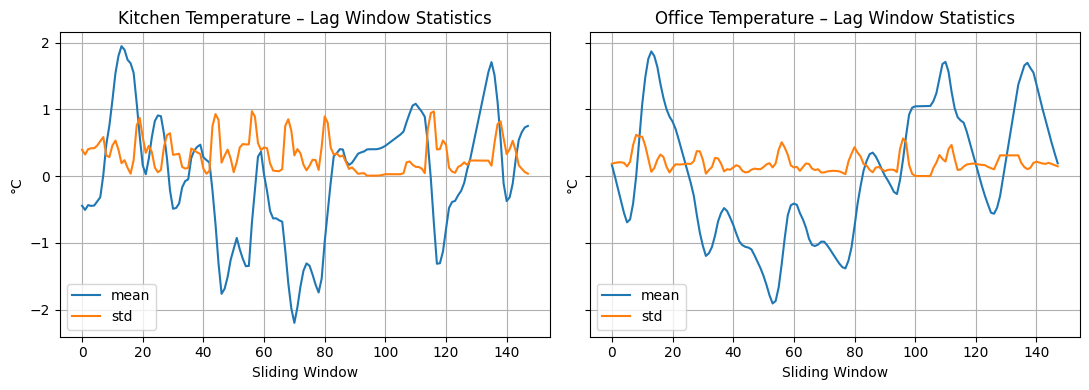

In [22]:
df_kitchen = pd.DataFrame(X_kitchen, columns=[f"lag_{i}" for i in range(4,0,-1)]).assign(target=y_kitchen)
df_office = pd.DataFrame(X_office, columns=[f"lag_{i}" for i in range(4,0,-1)]).assign(target=y_office)

fig, axs = plt.subplots(1, 2, figsize=(11, 4), sharey=True)  # 1 fila, 2 columnas
axs[0].plot(X_train_kit.mean(axis=1), label='mean')
axs[0].plot(X_train_kit.std(axis=1), label='std')
#(df_kitchen.T.describe().T)[['mean', 'std']].plot(ax=axs[0])
axs[0].set_title("Kitchen Temperature – Lag Window Statistics")
axs[0].set_xlabel("Sliding Window")
axs[0].set_ylabel("°C")
axs[0].grid(True)
axs[0].legend() 
axs[1].plot(X_train_off.mean(axis=1), label='mean')
axs[1].plot(X_train_off.std(axis=1), label='std')
axs[1].set_title("Office Temperature – Lag Window Statistics")
axs[1].set_xlabel("Sliding Window")
axs[1].set_ylabel("°C")
axs[1].legend() 
axs[1].grid(True)
plt.tight_layout()

- ***Example of created inputs:***

In [23]:
pd.DataFrame(data=np.concatenate((X_kitchen, y_kitchen.reshape(-1,1)), axis=1), columns=cols_kit+['target']).head()

,lag_4,lag_3,lag_2,lag_1,target
0,27.593333,27.483333,27.218334,27.055000,27.460000
1,27.483333,27.218334,27.055000,27.460000,27.641667
2,27.218334,27.055000,27.460000,27.641667,27.191667
3,27.055000,27.460000,27.641667,27.191667,27.065001
4,27.460000,27.641667,27.191667,27.065001,27.598334


## __________________________________________________________________________________________________________

## Model Training and Evaluation

In this section, the regression models are generated by splitting the dataset to create relationships between previous temperature values and the current one, as well as defining a dataset to evaluate the performance of the trained models.

At this stage of the project, simple approaches are applied to generate the regressors. **Linear Regression** and **Decision Forest** are among the most common methods, and they are used here for comparative purposes.

Additionally, **Ridge Regularization** is applied to the linear regression model to improve its performance and reduce potential overfitting. 
The objective at this stage is to demonstrate the feasibility of predicting future temperatures from IoT-based sensor measurements.


### Linear Regressor

The linear regressor is based on the use of **Statsmodels**, which defines the independent and dependent variables, 
the features generated through the sliding window method and the corresponding temperature values, respectively.


In [24]:
# Add constant term
X_train_kit_ols = sm.add_constant(X_train_kit, has_constant="add")
X_test_kit_ols  = sm.add_constant(X_test_kit, has_constant="add")
X_train_off_ols = sm.add_constant(X_train_off, has_constant="add")
X_test_off_ols  = sm.add_constant(X_test_off, has_constant="add")

# Define models
model_kit = sm.OLS(y_train_kit, X_train_kit_ols)
model_off = sm.OLS(y_train_off, X_train_off_ols)

# Fit models (HAC optional for time-dependent data)
results_kit = model_kit.fit(cov_type="HAC", cov_kwds={"maxlags": 4})  # or model_kit.fit(cov_type="HAC", cov_kwds={"maxlags": 4})
results_off = model_off.fit(cov_type="HAC", cov_kwds={"maxlags": 4})  # same here

# Predictions
y_pred_kit_ols = results_kit.predict(X_test_kit_ols)
y_pred_off_ols = results_off.predict(X_test_off_ols)

# Preparing sets to save generated models
artifact_kit = {
    "columns": ['constant'] + df_kitchen.columns[:-1].tolist(),        # p.ej. ["const","t-4","t-3","t-2","t-1"]
    "coef":    results_kit.params,        # np.array con β (incluye intercepto)
    "scaler": scaler_kit   # guarda si usaste StandardScaler u otro
}

artifact_off = {
    "columns": ['constant'] + df_kitchen.columns[:-1].tolist(),        # p.ej. ["const","t-4","t-3","t-2","t-1"]
    "coef":    results_off.params,        # np.array con β (incluye intercepto)
    "scaler": scaler_off   # guarda si usaste StandardScaler u otro
}

#### OLS Models:

- *Kitchen Regressor*

In [25]:
# Genera la expresión tipo "a × t² + b × t + c"
texto = "***T<sub>kit_temp, t</sub>*** = " + " + ".join(
    [f"**{coef:.2f}**×T<sub>kit_temp, t-{i+1}</sub>" for i, coef in enumerate(results_kit.summary2().tables[1]['Coef.'].values[1:])])
texto += f" + **{results_kit.summary2().tables[1]['Coef.'].values[0]:.2f}**"
Markdown(texto)

***T<sub>kit_temp, t</sub>*** = **0.02**×T<sub>kit_temp, t-1</sub> + **-0.01**×T<sub>kit_temp, t-2</sub> + **-0.19**×T<sub>kit_temp, t-3</sub> + **0.65**×T<sub>kit_temp, t-4</sub> + **27.59**

- *Office Regressor*

In [26]:
# Genera la expresión tipo "a × t² + b × t + c"
texto = "***T<sub>off_temp, t</sub>*** = " + " + ".join(
    [f"**{coef:.2f}**×T<sub>off_temp, t-{i+1}</sub>" for i, coef in enumerate(results_off.summary2().tables[1]['Coef.'].values[1:])])
texto += f" + **{results_off.summary2().tables[1]['Coef.'].values[0]:.2f}**"
Markdown(texto)

***T<sub>off_temp, t</sub>*** = **0.07**×T<sub>off_temp, t-1</sub> + **-0.11**×T<sub>off_temp, t-2</sub> + **-1.11**×T<sub>off_temp, t-3</sub> + **2.83**×T<sub>off_temp, t-4</sub> + **28.03**

#### OLS Models Summary

The following tables present the statistical summaries of the temperature prediction models  
for both locations, based on **Ordinary Least Squares (OLS)** regression.

- **OLS Summary for Kitchen Regressor:**

The table below shows the OLS regression summary for predicting kitchen temperatures.  
some of the most important metrics are:

- **R<sup>2<sup>** = **0.75** → The model explains approximately **75% of the total temperature variability**.  
- **Adjusted R<sup>2<sup>** = **0.75** → Adjusted coefficient of determination, which accounts for the number of predictors used in the model.  
- **F-statistic = 29.19 (p = 1.92e<sup>-10<sup>** **)** → The Fisher test indicates that the model explains a significant portion of the actual temperature variability.  
    The associated p-value confirms that the model is **statistically significant**.
- **Std. Err. (HAC correction)** → The models were fitted using the **Newey–West (HAC) estimator**,  
    providing more flexibility for handling correlated residuals — which is especially relevant for **time-series regression models**.

In [27]:
print(results_kit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     183.7
Date:                Sun, 09 Nov 2025   Prob (F-statistic):           2.75e-55
Time:                        20:35:22   Log-Likelihood:                 6.4893
No. Observations:                 148   AIC:                            -2.979
Df Residuals:                     143   BIC:                             12.01
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5919      0.019   1450.994      0.0

- **OLS Summary for Office Regressor:**

The table below shows the OLS regression summary for predicting kitchen temperatures.  
some of the most important metrics are:

- **R<sup>2<sup>** = **0.9g** → The model explains approximately **75% of the total temperature variability**.  
- **Adjusted R<sup>2<sup>** = **0.96** → Adjusted coefficient of determination, which accounts for the number of predictors used in the model.  
- **F-statistic = 270.8 (p = 2.50e<sup>-26<sup>** **)** → The Fisher test indicates that the model explains a significant portion of the actual temperature variability.  
    The associated p-value confirms that the model is **statistically significant**.
- **Std. Err. (HAC correction)** → The models were fitted using the **Newey–West (HAC) estimator**,  
    providing more flexibility for handling correlated residuals — which is especially relevant for **time-series regression models**.

In [28]:
print(results_off.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1459.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          8.54e-115
Time:                        20:35:22   Log-Likelihood:                -30.783
No. Observations:                 148   AIC:                             71.57
Df Residuals:                     143   BIC:                             86.55
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.0265      0.024   1146.183      0.0

#### Residual Error Analysis

To validate the generated linear regression models, even after applying the HAC method, residual errors can be analyzed to verify their **independence** and **homoscedasticity**. This step helps to identify any underlying patterns within the residuals that could introduce bias or reduce the reliability of the models.


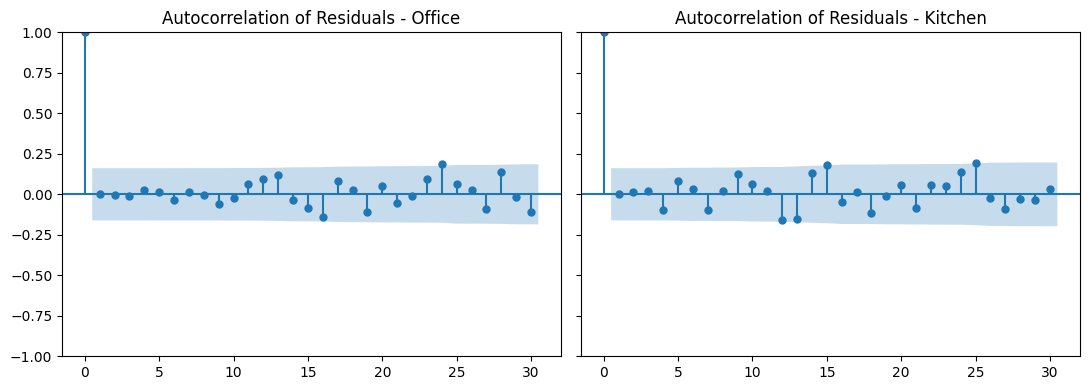

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

plot_acf(results_off.resid, lags=30, ax=axes[0])
axes[0].set_title("Autocorrelation of Residuals - Office")

plot_acf(results_kit.resid, lags=30, ax=axes[1])
axes[1].set_title("Autocorrelation of Residuals - Kitchen")

plt.tight_layout()

#### Multicollinearity Analysis

The following table shows the **Variance Inflation Factor (VIF)** values for the features used in both regressors. The estimated VIF values indicate a high degree of collinearity among the lag features.  

Normally, such levels of multicollinearity would be a concern in regression models. However, since this analysis is based on **time series data**, high correlations between consecutive time steps are expected. This behavior is consistent with the nature of temperature dynamics, where environmental conditions evolve gradually and do not exhibit rapid fluctuations over short time intervals.


In [30]:
X1 = sm.add_constant(df_kitchen[[f"lag_{i}" for i in range(4,0,-1)]])
X2 = sm.add_constant(df_office[[f"lag_{i}" for i in range(4,0,-1)]])

vif = pd.DataFrame({
    "Variable": X1.columns,
    "VIF_kitchen": [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])],
    "VIF_office": [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
})
vif


,Variable,VIF_kitchen,VIF_office
0,const,1924.624312,212.395417
1,lag_4,7.829950,45.440194
2,lag_3,19.842154,182.441296
3,lag_2,20.417088,178.788808
4,lag_1,8.299614,44.683365


#### Evaluation

Model performance is evaluated using the following metrics:

- **MAE (Mean Absolute Error)**: Linear measure of the average absolute differences between real and predicted values.  
- **RMSE (Root Mean Squared Error)**: Quadratic measure that penalizes larger errors more strongly than MAE.  
- **$R^{{2}}$ (Coefficient of Determination)**: Indicates how well the model predictions follow the actual measurement behavior.

In [31]:
# Performance Metrics
mae_kit  = mean_absolute_error(y_test_kit, y_pred_kit_ols)
rmse_kit = np.sqrt(mean_squared_error(y_test_kit, y_pred_kit_ols))   # √MSE for RMSE
r2_kit   = r2_score(y_test_kit, y_pred_kit_ols)

mae_off  = mean_absolute_error(y_test_off, y_pred_off_ols)
rmse_off = np.sqrt(mean_squared_error(y_test_off, y_pred_off_ols))
r2_off   = r2_score(y_test_off, y_pred_off_ols)

# Organize results
metrics = ['MAE', 'RMSE', '$R^{{2}}$']
results_kitchen = [mae_kit, rmse_kit, r2_kit]
results_office  = [mae_off, rmse_off, r2_off]

df_metrics_ols = pd.DataFrame({
    'Kitchen_Regressor': results_kitchen,
    'Office_Regressor':  results_office
}, index=metrics)

# Display
display(df_metrics_ols.style.format("{:.6f}").set_caption("Model Evaluation Metrics"))

,Kitchen_Regressor,Office_Regressor
MAE,0.249469,0.300336
RMSE,0.318733,0.417578
$R^{{2}}$,0.832316,0.943370


*In addition to the previously presented metrics, the following figures compare the temperatures predicted by both regressors with the actual measurements. These plots highlight the differences and similarities between real and predicted values, providing a clearer understanding of the models’ benefits and limitations.*

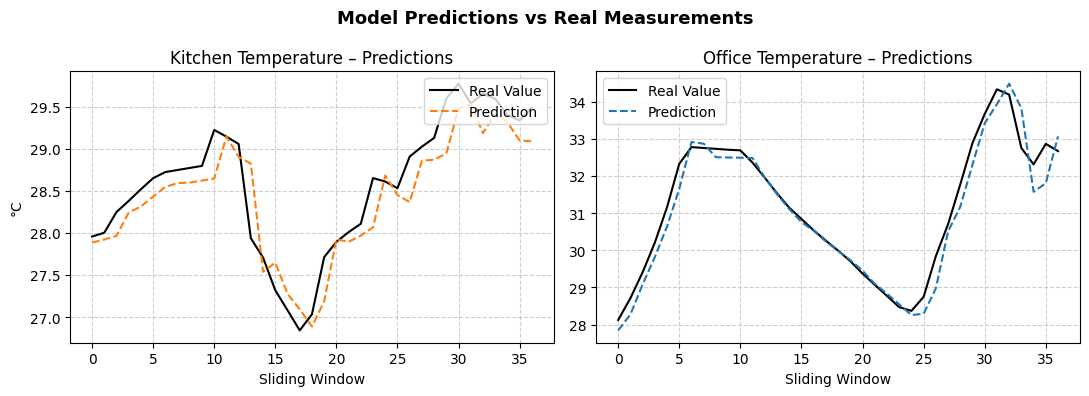

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4), sharey=False)

# --- Kitchen ---
axs[0].plot(y_test_kit, label='Real Value', color='black', linewidth=1.5)
axs[0].plot(y_pred_kit_ols, label='Prediction', color='tab:orange', linestyle='--')
axs[0].set_title("Kitchen Temperature – Predictions")
axs[0].set_xlabel("Sliding Window")
axs[0].set_ylabel("°C")
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)

# --- Office ---
axs[1].plot(y_test_off, label='Real Value', color='black', linewidth=1.5)
axs[1].plot(y_pred_off_ols, label='Prediction', color='tab:blue', linestyle='--')
axs[1].set_title("Office Temperature – Predictions")
axs[1].set_xlabel("Sliding Window")
axs[1].legend(loc='upper left')
axs[1].grid(True, linestyle='--', alpha=0.6)

fig.suptitle("Model Predictions vs Real Measurements", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


### Ridge Regression

From previous results, it can be concluded that the **Office regressor** performs better than the **Kitchen regressor**. This difference is likely due to overfitting to environmental patterns that do not account for building-specific factors such as air conditioning usage or temperature changes caused by heating processes (e.g., stove operation).

Therefore, **Ridge regularization** is applied to mitigate the overfitting to purely environmental factors. Since no additional contextual information is available regarding internal sources within the kitchen that may influence temperature readings, the regularization term helps stabilize the model and improve its generalization capability.

#### Generating training and test sets

The data is split into training and test subsets, following the same approach used for the OLS regression. This ensures a consistent evaluation framework across both models and allows for a fair comparison of performance metrics.

# Temporal split (no shuffling to preserve time order)
X_train_kit, X_test_kit, y_train_kit, y_test_kit = train_test_split(X_kitchen, y_kitchen, test_size=0.2, shuffle=False)
X_train_off, X_test_off, y_train_off, y_test_off = train_test_split(X_office, y_office, test_size=0.2, shuffle=False)

#### Finding the best parameters for Ridge Regularization

Since different values of $\alpha$ can be used, the **scikit-learn GridSearchCV** algorithm is employed to identify the optimal alpha value that provides the best performance according to the RMSE metric.

The **Root Mean Squared Error (RMSE)** is chosen as the evaluation criterion because it penalizes larger errors more strongly than metrics such as MAE, making it more sensitive to sudden temperature variations or model deviations. This allows a more reliable assessment of how well the model generalizes to unseen data, particularly in environments with occasional abrupt changes in sensor readings.


In [33]:
# Ridge model definition
ridge = Ridge(random_state=42)
# Range of alpha values to evaluate
param_grid = {"alpha": np.logspace(-3, 3, 25)}  # 0.001 → 1000
#  Cross-validation strategy for time series
tscv = TimeSeriesSplit(n_splits=5)

# Grid search implementation using RMSE as evaluation metric ---
grid = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    refit=True)

# Fit model on training data ---
grid.fit(X_train_kit, y_train_kit)

# Retrieve best alpha and corresponding model ---
best_alpha = grid.best_params_["alpha"]
best_model = grid.best_estimator_
print(f"Best alpha (kitchen): {best_alpha:.4f}")

Best alpha (kitchen): 1.0000


#### Improving Linear Regression using Ridge Regularization

Once the optimal $\alpha$ value to reduce overfitting in the linear regression model is known, the Ridge regressor is trained as follows:


In [34]:
# Ridge model
ridge_kit = best_model
y_pred_ridge_kit = ridge_kit.predict(X_test_kit)

- ***Ridge regression equation:***

In [35]:
# Genera la expresión tipo "a × t² + b × t + c"
texto = "***T<sub>kit_temp, t</sub>*** = " + " + ".join(
    [f"**{coef:.4f}**×T<sub>kit_temp, t-{i+1}</sub>" for i, coef in enumerate(ridge_kit.coef_[::-1])])
texto += f" + **{ridge_kit.intercept_:.4f}**"
Markdown(texto)

***T<sub>kit_temp, t</sub>*** = **0.6195**×T<sub>kit_temp, t-1</sub> + **-0.1476**×T<sub>kit_temp, t-2</sub> + **-0.0222**×T<sub>kit_temp, t-3</sub> + **0.0198**×T<sub>kit_temp, t-4</sub> + **27.5919**

#### Evaluation

The Ridge regressor shows improved performance across all evaluated metrics, achieving lower MAE and RMSE values and a higher $R^{{2}}$ compared to the baseline linear model.  The red curve demonstrates smoother predictions that follow the general temperature trend while avoiding the sharp oscillations observed in the unregularized model, indicating that Ridge regularization successfully reduced overfitting to noise in the kitchen temperature data.

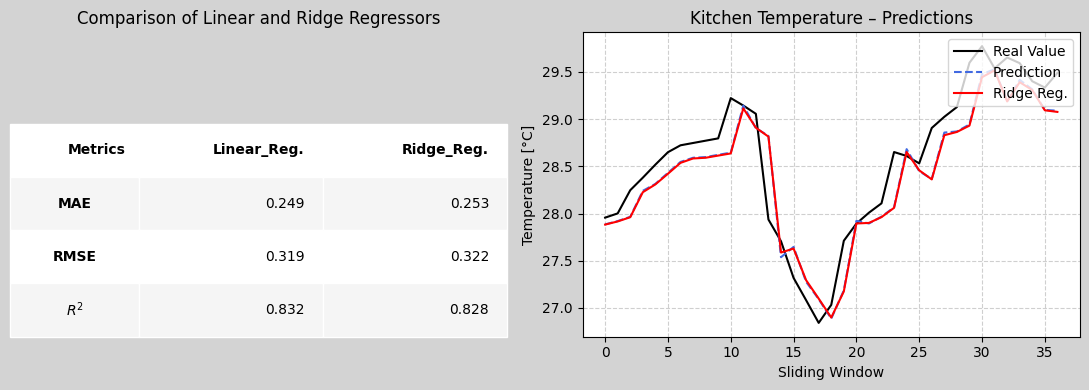

In [36]:
# Performance Metrics
mae_ridge_kit  = mean_absolute_error(y_test_kit, y_pred_ridge_kit)
rmse_ridge_kit = np.sqrt(mean_squared_error(y_test_kit, y_pred_ridge_kit))
r2_ridge_kit   = r2_score(y_test_kit, y_pred_ridge_kit)

# Performance Metrics
results_kitchen = [mae_kit, rmse_kit, r2_kit]
results_Kitchen_Rig  = [mae_ridge_kit, rmse_ridge_kit, r2_ridge_kit]

# Generating table of results
df_metrics_rid = pd.DataFrame({
    'Metrics':['MAE', 'RMSE', '$R^{{2}}$'],
    'Linear_Reg.': results_kitchen,
    'Ridge_Reg.':  results_Kitchen_Rig}).round(3)

# Presenting results
Ridge_Regression_Results(df_metrics_rid, y_test_kit, y_pred_kit_ols, y_pred_ridge_kit)

### Random Forest Regressor

While linear and regularized models (OLS and Ridge) capture the main tendencies in temperature variation, they may fail to model more complex, nonlinear relationships between features such as humidity and time-related patterns.

To address this, a **Random Forest Regressor** is implemented.  
This ensemble method combines multiple decision trees trained on random subsets of the data and features, providing better robustness and reducing the impact of noise or unmodeled interactions in the kitchen environment.


#### Training Models using Grid Search

In [37]:
# Base model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
# Hyperparameters to evaluate
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]}

# Temporal cross-validation
tscv = TimeSeriesSplit(n_splits=5)
# Run grid search for each dataset
best_params = {}
for X_train, y_train, location in [(X_train_kit, y_train_kit, "Kitchen"),(X_train_off, y_train_off, "Office")]:
    grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    refit=True    )
    grid_rf.fit(X_train, y_train)
    best_params[location] = grid_rf.best_params_
    if location == 'Kitchen':
        Kitchen_RF = grid_rf.best_estimator_
    elif location == 'Office': 
        Office_RF = grid_rf.best_estimator_

print("Best hyperparameters found:")
print(best_params)


Best hyperparameters found:
{'Kitchen': {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}, 'Office': {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}}


#### Models Evaluation

Although Random Forest is a more flexible model capable of capturing nonlinear interactions, the results show that in this case, the **linear models (OLS and Ridge)** perform better in both the Kitchen and Office environments.

The temperature dynamics appear to be predominantly linear, with smooth autoregressive behavior that does not require the additional complexity of ensemble models. The Ridge regression therefore provides a better balance between interpretability, generalization, and predictive accuracy.

- ***Performance Metrics:***


In [38]:
# Evaluación
y_pred_rf_kit = Kitchen_RF.predict(X_test_kit)
y_pred_rf_off = Office_RF.predict(X_test_kit)

mae_rf_kit  = mean_absolute_error(y_test_kit, y_pred_rf_kit)
mae_rf_off = mean_absolute_error(y_test_kit, y_pred_rf_off)
rmse_rf_kit = np.sqrt(mean_squared_error(y_test_kit, y_pred_kit_ols))
rmse_rf_off = np.sqrt(mean_squared_error(y_test_kit, y_pred_off_ols))
r2_rf_kit   = r2_score(y_test_kit, y_pred_rf_kit)
r2_rf_off   = r2_score(y_test_kit, y_pred_rf_off)

df_metrics_rf = pd.DataFrame({'Kitchen_RF.': [mae_rf_kit, rmse_rf_kit, r2_rf_kit],
                           'Office_RF.':  [mae_rf_off, rmse_rf_off, r2_rf_off]}, 
                           index=['MAE', 'RMSE', '$R^{{2}}$'])

display(df_metrics_rf)

,Kitchen_RF.,Office_RF.
MAE,0.475395,1.468762
RMSE,0.318733,2.830360
$R^{{2}}$,0.377292,-3.180109


- ***Models Predictions Comparisons:***

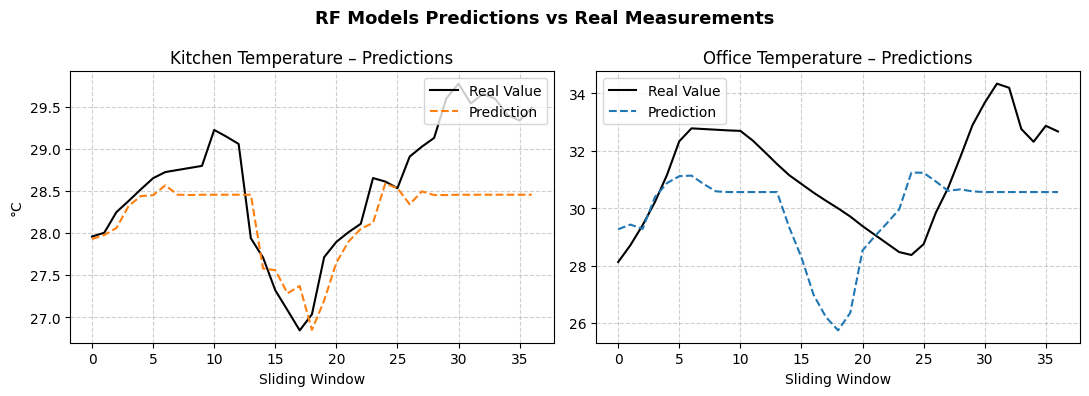

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4), sharey=False)

# --- Kitchen ---
axs[0].plot(y_test_kit, label='Real Value', color='black', linewidth=1.5)
axs[0].plot(y_pred_rf_kit, label='Prediction', color='tab:orange', linestyle='--')
axs[0].set_title("Kitchen Temperature – Predictions")
axs[0].set_xlabel("Sliding Window")
axs[0].set_ylabel("°C")
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)

# --- Office ---
axs[1].plot(y_test_off, label='Real Value', color='black', linewidth=1.5)
axs[1].plot(y_pred_rf_off, label='Prediction', color='tab:blue', linestyle='--')
axs[1].set_title("Office Temperature – Predictions")
axs[1].set_xlabel("Sliding Window")
axs[1].legend(loc='upper left')
axs[1].grid(True, linestyle='--', alpha=0.6)

fig.suptitle("RF Models Predictions vs Real Measurements", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Conclusion

The summarized results confirm that **linear models (OLS and Ridge)** outperform the Random Forest regressors in both environments. The Ridge model achieves similar accuracy to OLS while improving stability, whereas the Random Forest introduces unnecessary complexity, leading to reduced performance, particularly in the Kitchen dataset.

In [40]:
df_metrics = pd.concat([df_metrics_ols, df_metrics_rid.set_index('Metrics')[['Ridge_Reg.']].rename(columns={'Ridge_Reg.':'Kitchen_Ridge_Reg.'})], axis=1)
df_metrics = pd.concat([df_metrics, df_metrics_rf], axis=1)
display(df_metrics.round(3))

,Kitchen_Regressor,Office_Regressor,Kitchen_Ridge_Reg.,Kitchen_RF.,Office_RF.
MAE,0.249,0.300,0.253,0.475,1.469
RMSE,0.319,0.418,0.322,0.319,2.830
$R^{{2}}$,0.832,0.943,0.828,0.377,-3.180


The following comparison provides evidence supporting the conclusion that the underlying temperature patterns are predominantly linear, and that model regularization (Ridge) offers the best trade-off between accuracy and stability.


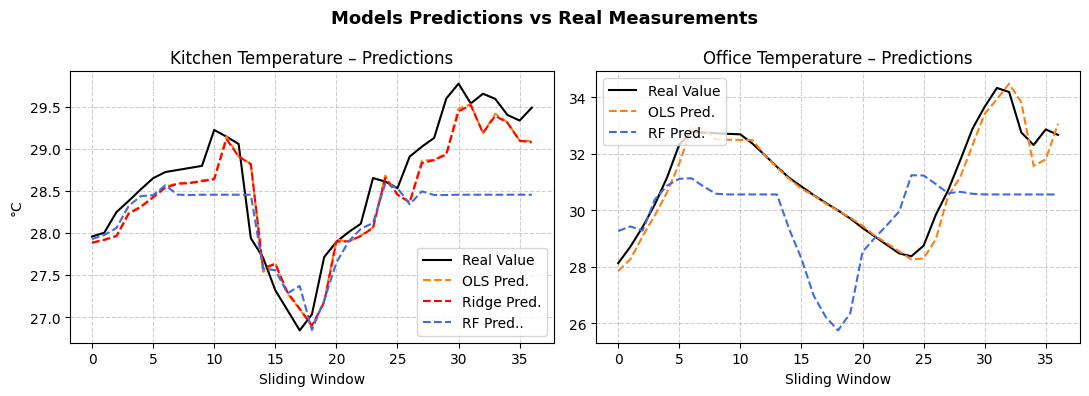

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4), sharey=False)
# Kitchen
axs[0].plot(y_test_kit, label='Real Value', color='black', linewidth=1.5)
axs[0].plot(y_pred_kit_ols, label='OLS Pred.', color='tab:orange', linestyle='--')
axs[0].plot(y_pred_ridge_kit, label='Ridge Pred.', color='red', linestyle='--')
axs[0].plot(y_pred_rf_kit, label='RF Pred..', color='royalblue', linestyle='--')
axs[0].set_title("Kitchen Temperature – Predictions")
axs[0].set_xlabel("Sliding Window")
axs[0].set_ylabel("°C")
axs[0].legend(loc='lower right')
axs[0].grid(True, linestyle='--', alpha=0.6)
# Office
axs[1].plot(y_test_off, label='Real Value', color='black', linewidth=1.5)
axs[1].plot(y_pred_off_ols, label='OLS Pred.', color='tab:orange', linestyle='--')
axs[1].plot(y_pred_rf_off, label='RF Pred.', color='royalblue', linestyle='--')
axs[1].set_title("Office Temperature – Predictions")
axs[1].set_xlabel("Sliding Window")
axs[1].legend(loc='upper left')
axs[1].grid(True, linestyle='--', alpha=0.6)

fig.suptitle("Models Predictions vs Real Measurements", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Saving Models For Deployment

In [42]:
# Si usas escalado, ajusta aquí
joblib.dump(artifact_kit, "models/kitchen_ols_artifact.pkl")
joblib.dump(artifact_off, "models/office_ols_artifact.pkl")
joblib.dump(ridge_kit, "models/kitchen_ridge_model.pkl");

## __________________________________________________________________________________________________________

## Next Steps: MLOps Integration

The current analysis provides a complete modeling foundation for temperature forecasting in IoT environments, demonstrating that linear models such as Ridge regression deliver a strong balance between accuracy, interpretability, and stability.  

The next stage focuses on transforming this experimentation workflow into a reproducible **MLOps pipeline**.  
This includes the following key components:

1. **Model Tracking and Versioning:**  
   Implementing experiment tracking with tools such as *MLflow* or *DVC* to store model parameters, metrics, and versions.

2. **Automated Retraining:**  
   Setting up a retraining pipeline that periodically checks for **data drift** or **model degradation**, triggering retraining if performance metrics exceed defined thresholds.

3. **Model Registry and Deployment:**  
   Registering the selected model (Ridge) as a deployable artifact and serving predictions via an API or a lightweight microservice.

4. **Monitoring and Continuous Improvement:**  
   Logging real-time sensor data, comparing live performance with historical baselines, and using dashboards (e.g., *Grafana* or *Streamlit*) to visualize model behavior.

These steps will ensure that the model remains consistent, explainable, and easily maintainable in production environments, completing the transition from experimentation to a fully operational MLOps workflow.


## __________________________________________________________________________________________________________
# FIN